# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

For this practical application project, our aim is to develop a predictive model capable of accurately forecasting the sales price of used cars based on the provided dataset. This involves data cleaning and employing feature engineering techniques to create, select, and transform variables that influence used car prices. Additionally, we will use feature selection methods to identify and retain only those features that significantly contribute to predicting the sale price. We will also employ validation techniques to evaluate the quality of the model. Ultimately, our goal is to provide a list of the key drivers that significantly impact used car sales prices.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [370]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import set_config
set_config(display="diagram")
from sklearn.linear_model import Ridge
from sklearn.cluster import DBSCAN
from sklearn.impute import KNNImputer

import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [216]:
# Load dataset
df = pd.read_csv('data/vehicles.csv')
# Review columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [217]:
#Review shape of data to determine how many records exist
df.shape

(426880, 18)

In [218]:
#Drop VIN column as it should be unique to every car
df.drop(columns=['VIN'], inplace=True)

In [219]:
#Drop Size due to  high number of missing values
df.drop(columns=['size'], inplace=True)

# Review Float and Integer Data

In [220]:
#Review statistics of integer columns
df.select_dtypes(include=['int', 'float64']).describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


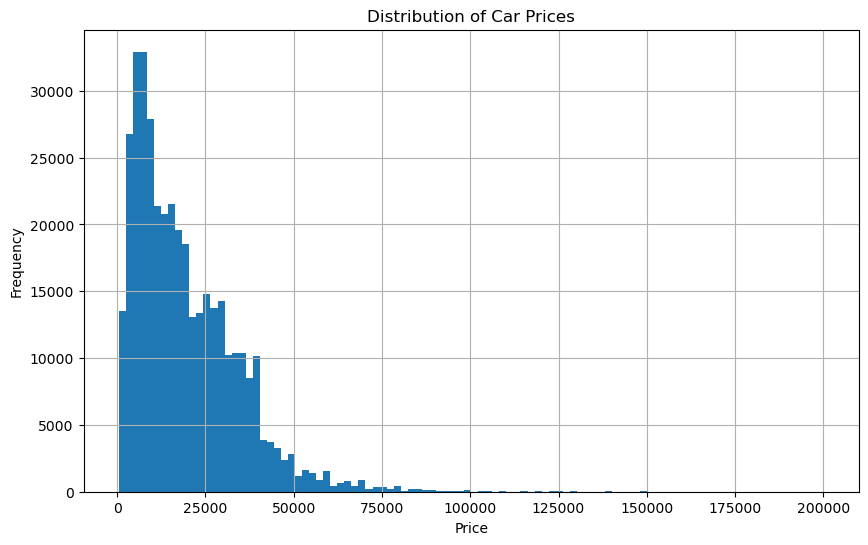

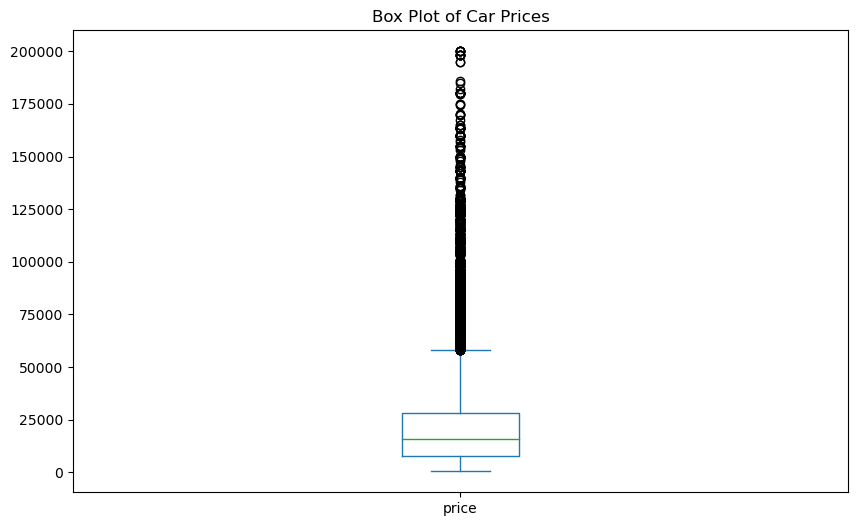

In [221]:
#Price STD is very high need to review data.
#Reasonable price for used cars is between 500 and 200,000
df = df[(df['price'] > 500 ) & (df['price'] <= 200000)]

#Visualize data
# Histogram
plt.figure(figsize=(10, 6))
df['price'].hist(bins=100)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Car Prices')
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
df['price'].plot.box()
plt.title('Box Plot of Car Prices')
plt.show()

In [222]:
#Review statistics of integer columns
df.select_dtypes(include=['int', 'float64']).describe()

,id,price,year,odometer
count,3.836410e+05,383641.000000,382469.000000,3.815200e+05
mean,7.311464e+09,19362.967152,2010.974568,9.839207e+04
std,4.475651e+06,14978.647385,9.602507,1.892401e+05
min,7.207408e+09,501.000000,1900.000000,0.000000e+00
25%,7.308083e+09,7900.000000,2008.000000,3.813000e+04
50%,7.312579e+09,15970.000000,2013.000000,8.765600e+04
75%,7.315243e+09,27990.000000,2017.000000,1.360000e+05
max,7.317101e+09,200000.000000,2022.000000,1.000000e+07


In [223]:
#Price STD is very high need to review data.
#Reasonable price for used cars is between 500 and 100,000
df = df[(df['price'] > 500 ) & (df['price'] <= 200000)]

In [224]:
#Drop Null values from year
df.dropna(subset=['year'], inplace=True)

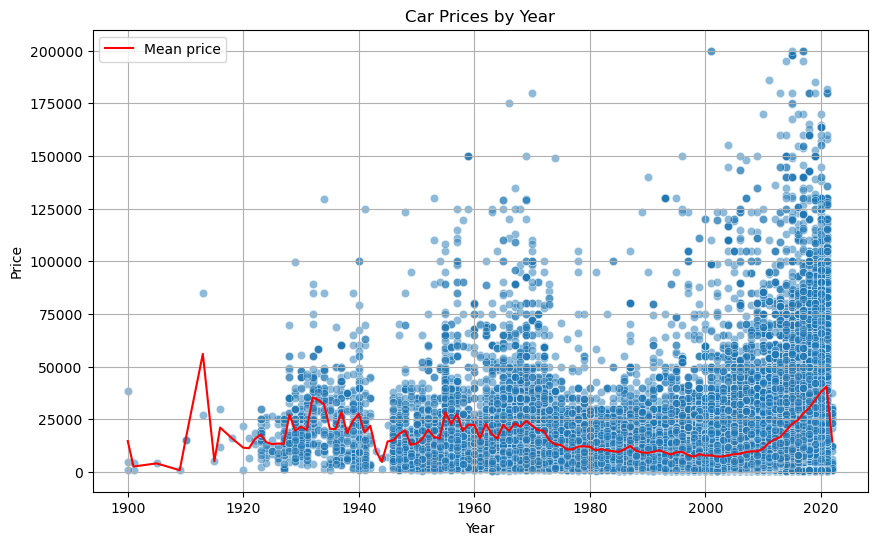

In [225]:
#Scatterplot of year data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='price', data=df, alpha=0.5)
sns.lineplot(x='year', y='price', data=df, errorbar=None, estimator='mean', color='red', label='Mean price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Car Prices by Year')
plt.legend()
plt.grid(True)
plt.show()

In [226]:
#Drop Null values from odomtor
df.dropna(subset=['odometer'], inplace=True)

In [227]:
#odometer STD is very high need to review data. Need to remove unreasonably high odometer data:
df = df[(df['odometer'] >= 0) & (df['odometer'] <= 500000)]

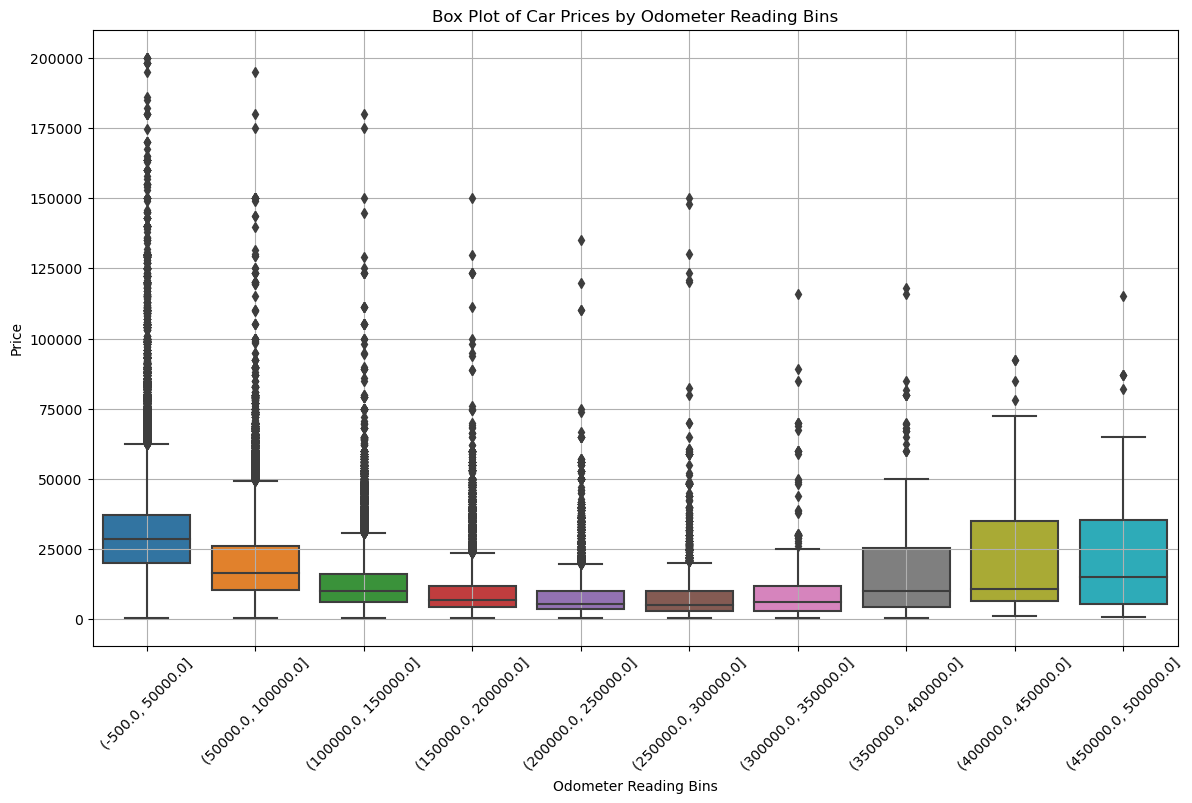

In [228]:
# Create bins for odometer readings
df['odometer_bin'] = pd.cut(df['odometer'], bins=10)

plt.figure(figsize=(14, 8))
sns.boxplot(x='odometer_bin', y='price', data=df)
plt.xlabel('Odometer Reading Bins')
plt.ylabel('Price')
plt.title('Box Plot of Car Prices by Odometer Reading Bins')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

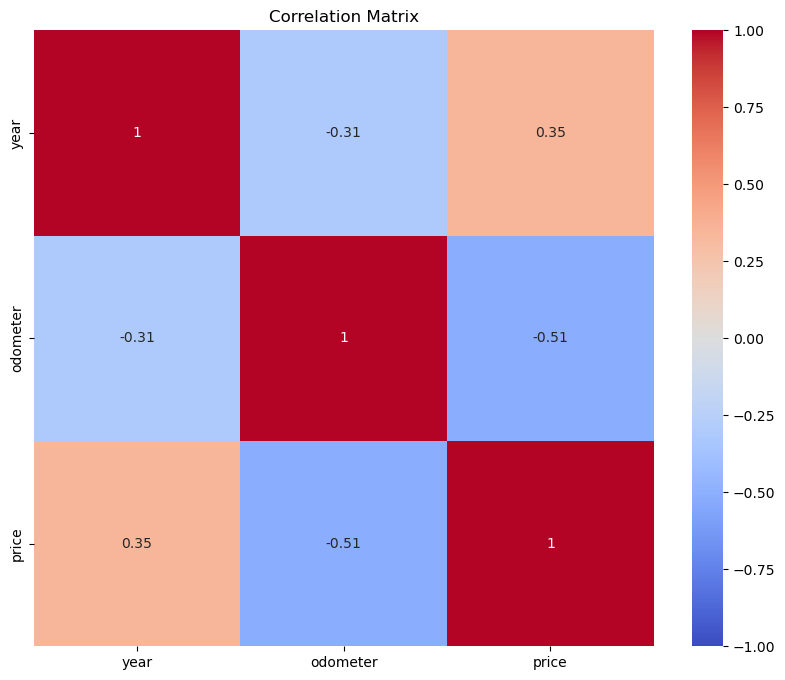

In [229]:
#Run a correlation matrix against integer float columns:
correlation_matrix = df[['year','odometer', 'price']].corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()
#From heatmap it looks like price has moderate positive correlation with price while odometer has a stronger negative correlation with price

In [230]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379273 entries, 27 to 426879
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   id            379273 non-null  int64   
 1   region        379273 non-null  object  
 2   price         379273 non-null  int64   
 3   year          379273 non-null  float64 
 4   manufacturer  365556 non-null  object  
 5   model         374909 non-null  object  
 6   condition     236542 non-null  object  
 7   cylinders     224640 non-null  object  
 8   fuel          377150 non-null  object  
 9   odometer      379273 non-null  float64 
 10  title_status  372795 non-null  object  
 11  transmission  377760 non-null  object  
 12  drive         264146 non-null  object  
 13  type          298036 non-null  object  
 14  paint_color   269761 non-null  object  
 15  state         379273 non-null  object  
 16  odometer_bin  379273 non-null  category
dtypes: category(1), float64(2), int64

# Review of Categorical Data

In [231]:
# Review Unique Values for each column:
def get_unique_values_for_categorical_columns(df):
    unique_values = {}
    
    # Get categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    # Get unique values for each categorical column
    for col in categorical_columns:
        unique_values[col] = df[col].unique().tolist()
    
    return unique_values


unique_values = get_unique_values_for_categorical_columns(df)

# Print values for each categorical column
for col, values in unique_values.items():
    print(f"Column: {col}")
    print(f"Unique Values: {values}\n")

Column: region
Unique Values: ['auburn', 'birmingham', 'dothan', 'florence / muscle shoals', 'gadsden-anniston', 'huntsville / decatur', 'mobile', 'montgomery', 'tuscaloosa', 'anchorage / mat-su', 'fairbanks', 'kenai peninsula', 'southeast alaska', 'flagstaff / sedona', 'mohave county', 'phoenix', 'prescott', 'show low', 'sierra vista', 'tucson', 'yuma', 'fayetteville', 'fort smith', 'jonesboro', 'little rock', 'texarkana', 'bakersfield', 'chico', 'fresno / madera', 'gold country', 'hanford-corcoran', 'humboldt county', 'imperial county', 'inland empire', 'los angeles', 'mendocino county', 'merced', 'modesto', 'monterey bay', 'orange county', 'palm springs', 'redding', 'reno / tahoe', 'sacramento', 'san diego', 'san luis obispo', 'santa barbara', 'santa maria', 'SF bay area', 'siskiyou county', 'stockton', 'susanville', 'ventura county', 'visalia-tulare', 'yuba-sutter', 'boulder', 'colorado springs', 'denver', 'eastern CO', 'fort collins / north CO', 'high rockies', 'pueblo', 'western 

In [232]:
#Drop region and state as they are not factors associated with the car
df.drop(columns=['state', 'region'], inplace=True)


In [233]:
#Drop model as values is column are not standard (for example too many variations of the same model and manufacturer information in model column etc)
df.drop(columns=['model'], inplace=True)

In [234]:
df['manufacturer'].isnull().value_counts()
#remove manufacture null records total is 13717
df.dropna(subset=['manufacturer'], inplace=True)

In [235]:
#Review Condition Data
df['condition'].value_counts()

condition
good         113039
excellent     87742
like new      18613
fair           5898
new             912
salvage         473
Name: count, dtype: int64

In [236]:
# Remove null condition data
df.dropna(subset=['condition'], inplace=True)

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226677 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   id            226677 non-null  int64   
 1   price         226677 non-null  int64   
 2   year          226677 non-null  float64 
 3   manufacturer  226677 non-null  object  
 4   condition     226677 non-null  object  
 5   cylinders     163361 non-null  object  
 6   fuel          226661 non-null  object  
 7   odometer      226677 non-null  float64 
 8   title_status  221966 non-null  object  
 9   transmission  226654 non-null  object  
 10  drive         172224 non-null  object  
 11  type          198415 non-null  object  
 12  paint_color   180979 non-null  object  
 13  odometer_bin  226677 non-null  category
dtypes: category(1), float64(2), int64(2), object(9)
memory usage: 24.4+ MB


In [238]:
#Review cylinder counts
df['cylinders'].value_counts()

cylinders
6 cylinders     64516
4 cylinders     48148
8 cylinders     47779
5 cylinders      1176
10 cylinders      870
other             477
3 cylinders       315
12 cylinders       80
Name: count, dtype: int64

In [239]:
#Remove other as it does not provide useful information
df = df[df['cylinders'] != 'other']

In [240]:
df['cylinders'].value_counts()

cylinders
6 cylinders     64516
4 cylinders     48148
8 cylinders     47779
5 cylinders      1176
10 cylinders      870
3 cylinders       315
12 cylinders       80
Name: count, dtype: int64

In [241]:
#Extract number of cylinders from cylinder column
df['cylinders_num'] = df['cylinders'].str.extract('(\d+)').fillna(0).astype(int)

In [242]:
#Review fuel column
df['fuel'].value_counts()

fuel
gas         191964
other        19560
diesel       10435
hybrid        3280
electric       945
Name: count, dtype: int64

In [243]:
#Review title_status column
df['title_status'].value_counts()

title_status
clean         212617
rebuilt         4947
salvage         2330
lien            1227
missing          330
parts only        72
Name: count, dtype: int64

In [244]:
#Review transmission column
df['transmission'].value_counts()

transmission
automatic    156939
other         55972
manual        13266
Name: count, dtype: int64

In [245]:
#dropping transmission column as it has too many "other" records
df.drop(columns=['transmission'], inplace=True)

In [246]:
#Review drive column
df['drive'].value_counts()

drive
4wd    69867
fwd    63153
rwd    38844
Name: count, dtype: int64

In [247]:
#Review type column
df['type'].value_counts()

type
sedan          53696
SUV            42050
pickup         25804
truck          18194
other          13571
coupe          13131
hatchback      11748
wagon           5689
convertible     5096
van             4801
mini-van        3472
offroad          535
bus              209
Name: count, dtype: int64

In [248]:
#Review paint_color column
df['paint_color'].value_counts()


paint_color
white     45829
black     38492
silver    25928
blue      19921
red       19667
grey      15496
green      4847
brown      4590
custom     2842
yellow     1291
orange     1261
purple      438
Name: count, dtype: int64

In [261]:
#Drop null values from df
df_cleaned = df.dropna()

In [262]:
#Drop id column as it irrelavant
df_cleaned = df_cleaned.drop(columns=['id'])

In [263]:
#Drop bin column used for visualization
df_cleaned.drop(columns=['odometer_bin'], inplace=True)

In [264]:
#drop cylinders since we are using numbers instead 
df_cleaned.drop(columns=['cylinders'], inplace=True)

In [266]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110414 entries, 31 to 426878
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          110414 non-null  int64  
 1   year           110414 non-null  float64
 2   manufacturer   110414 non-null  object 
 3   condition      110414 non-null  object 
 4   fuel           110414 non-null  object 
 5   odometer       110414 non-null  float64
 6   title_status   110414 non-null  object 
 7   drive          110414 non-null  object 
 8   type           110414 non-null  object 
 9   paint_color    110414 non-null  object 
 10  cylinders_num  110414 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 10.1+ MB


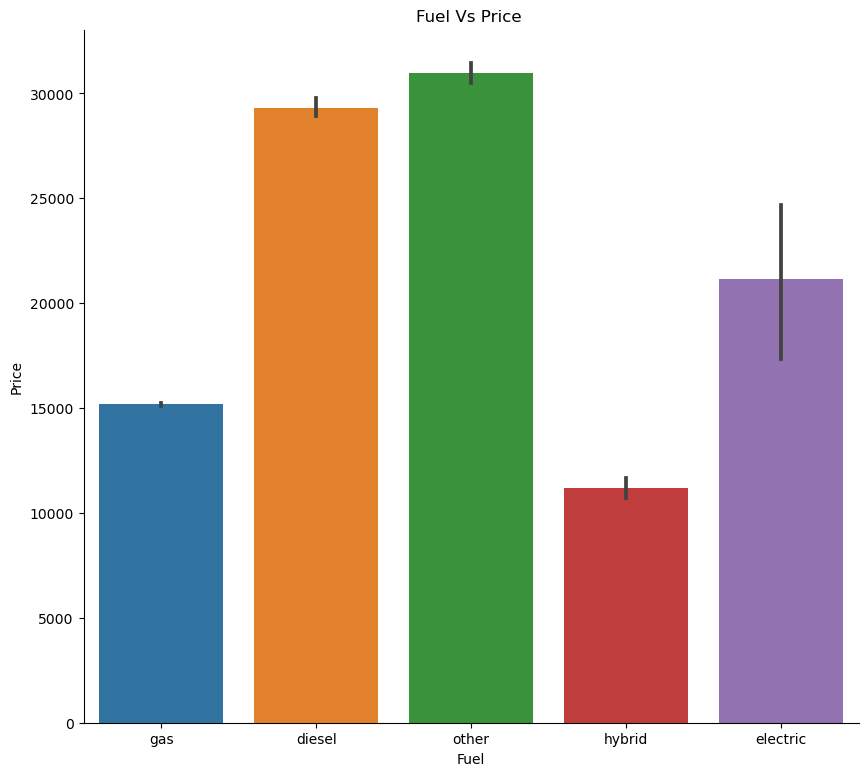

In [357]:
#fuel column after clean
plt.figure(figsize=(10,9))
sns.barplot(x = df_cleaned['fuel'],y = df_cleaned['price'])
plt.title('Fuel Vs Price ')
plt.xlabel('Fuel')
plt.ylabel('Price')
sns.despine()
plt.show()

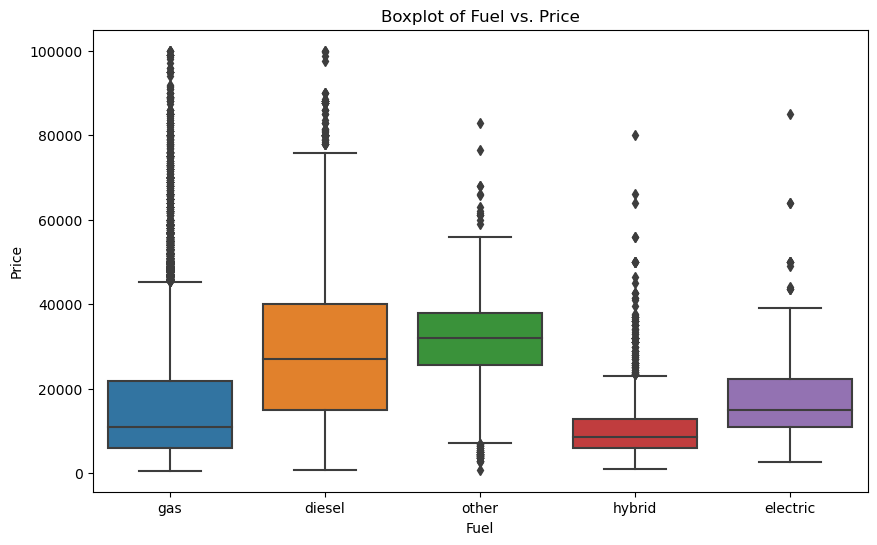

In [358]:
# Create the boxplot of fuel to get a better idea
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel', y='price', data=df_cleaned)
plt.title('Boxplot of Fuel vs. Price')
plt.xlabel('Fuel')
plt.ylabel('Price')
plt.show()

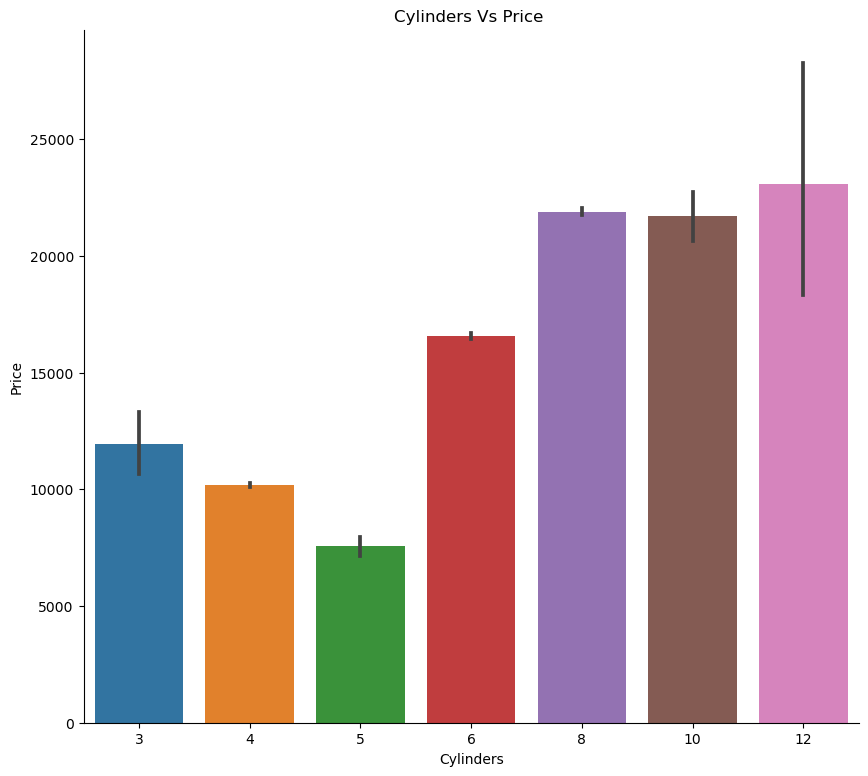

In [356]:

#Cylinders after clean
plt.figure(figsize=(10,9))
sns.barplot(x = df_cleaned['cylinders_num'],y = df_cleaned['price'])
plt.title('Cylinders Vs Price ')
plt.xlabel('Cylinders')
plt.ylabel('Price')
sns.despine()
plt.show()

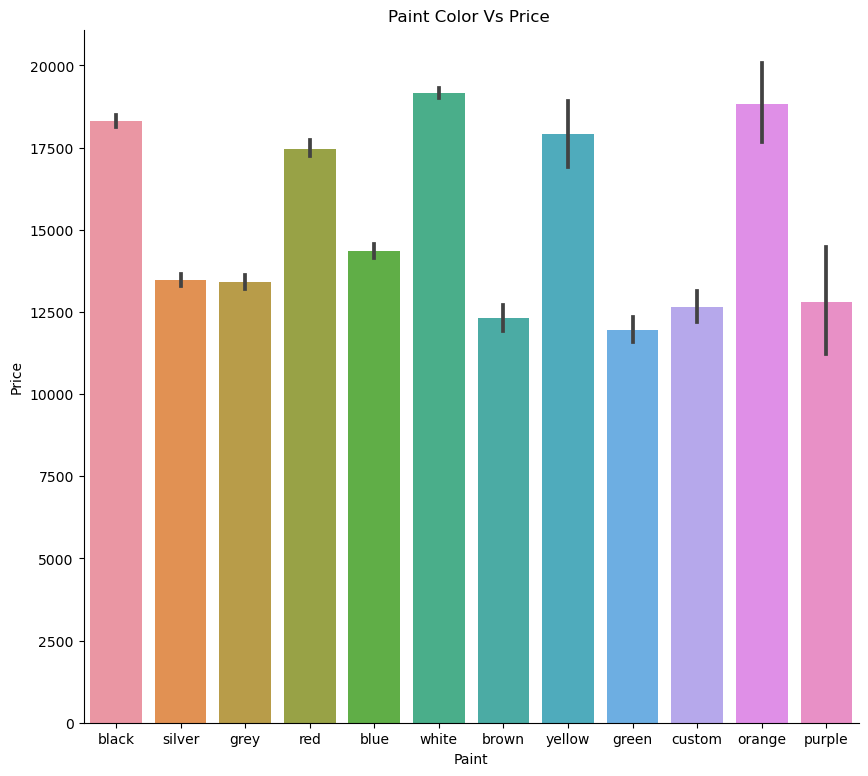

In [268]:
#Paint color vs price
plt.figure(figsize=(10,9))
sns.barplot(x = df_cleaned['paint_color'],y = df_cleaned['price'])
plt.title('Paint Color Vs Price ')
plt.xlabel('Paint')
plt.ylabel('Price')
sns.despine()
plt.show()

In [353]:
#Review title_status column
df['title_status'].value_counts()

title_status
clean         212617
rebuilt         4947
salvage         2330
lien            1227
missing          330
parts only        72
Name: count, dtype: int64

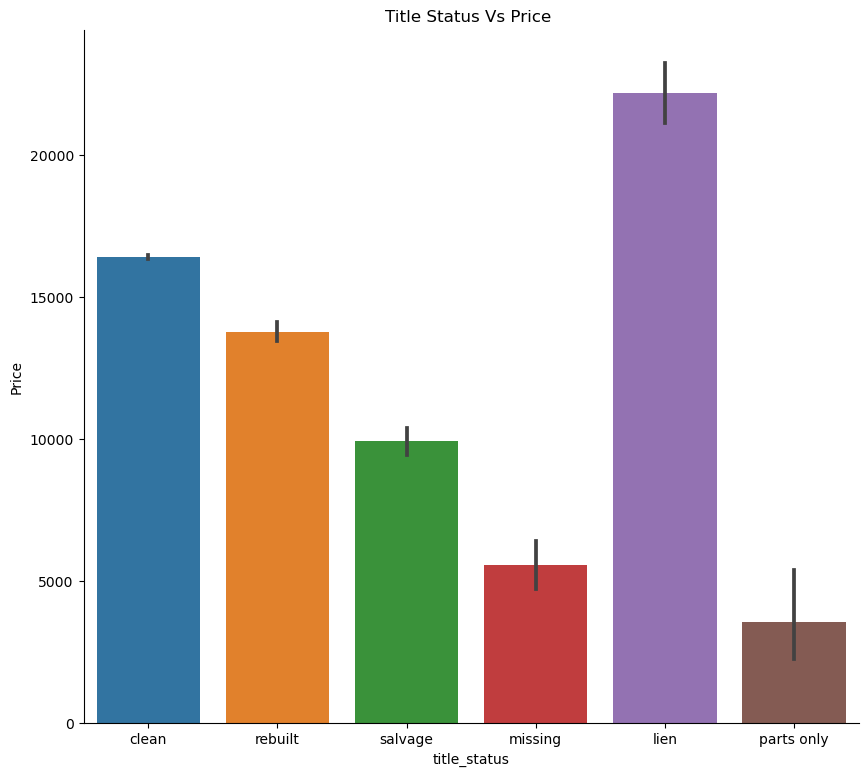

In [291]:
#Title Status color vs price
plt.figure(figsize=(10,9))
sns.barplot(x = df_cleaned['title_status'],y = df_cleaned['price'])
plt.title('Title Status Vs Price ')
plt.xlabel('title_status')
plt.ylabel('Price')
sns.despine()
plt.show()

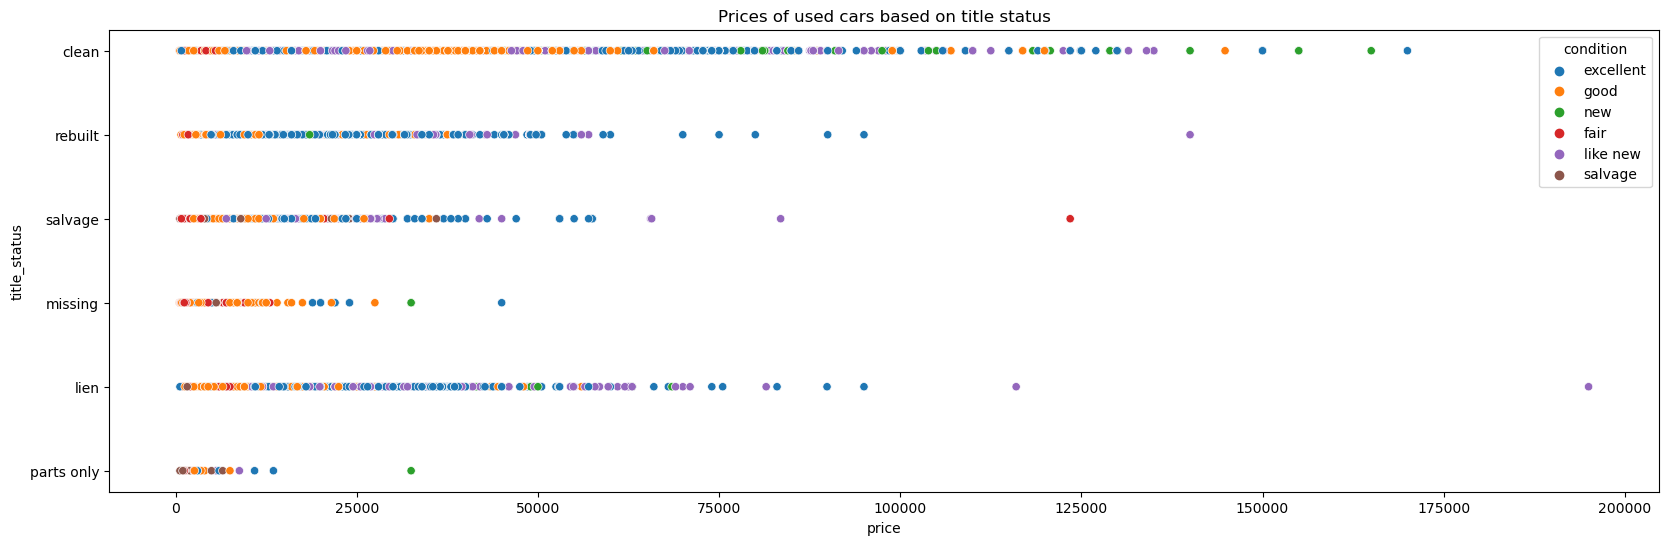

In [293]:
# Create scatter plot
plt.figure(figsize=(20, 6))
scatter = sns.scatterplot(data=df_cleaned, x="price", y="title_status", hue='condition', sizes=(20, 200))

# Add title
plt.title('Prices of used cars based on title status')

# Show plot
plt.show()

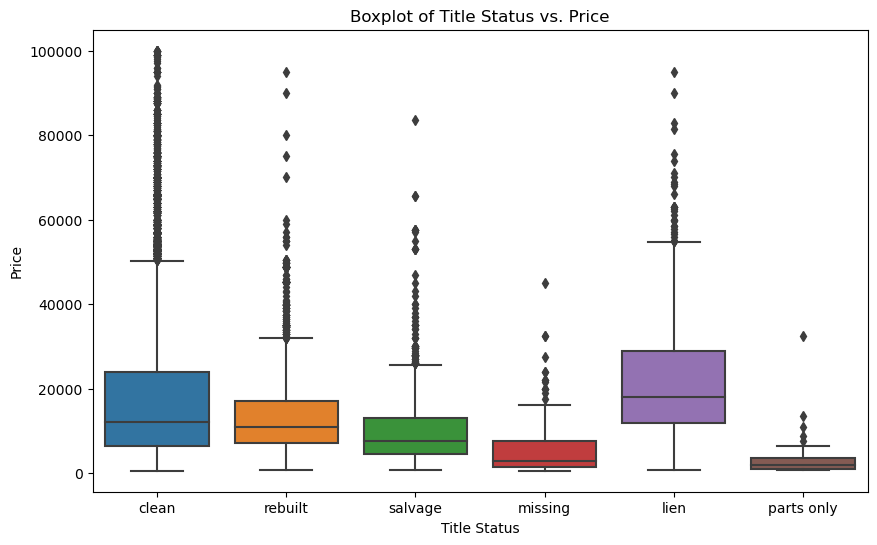

In [313]:
# Create the boxplot of title to get a better idea of lien
plt.figure(figsize=(10, 6))
sns.boxplot(x='title_status', y='price', data=df_cleaned)
plt.title('Boxplot of Title Status vs. Price')
plt.xlabel('Title Status')
plt.ylabel('Price')
plt.show()

In [314]:
#After looking into market research we should ignore title status as a predictor as cars with liens tend to have higher prices due to the owners needing to pay back loans and interest of the car.
#drop cylinders since we are using numbers instead 
df_cleaned.drop(columns=['title_status'], inplace=True)

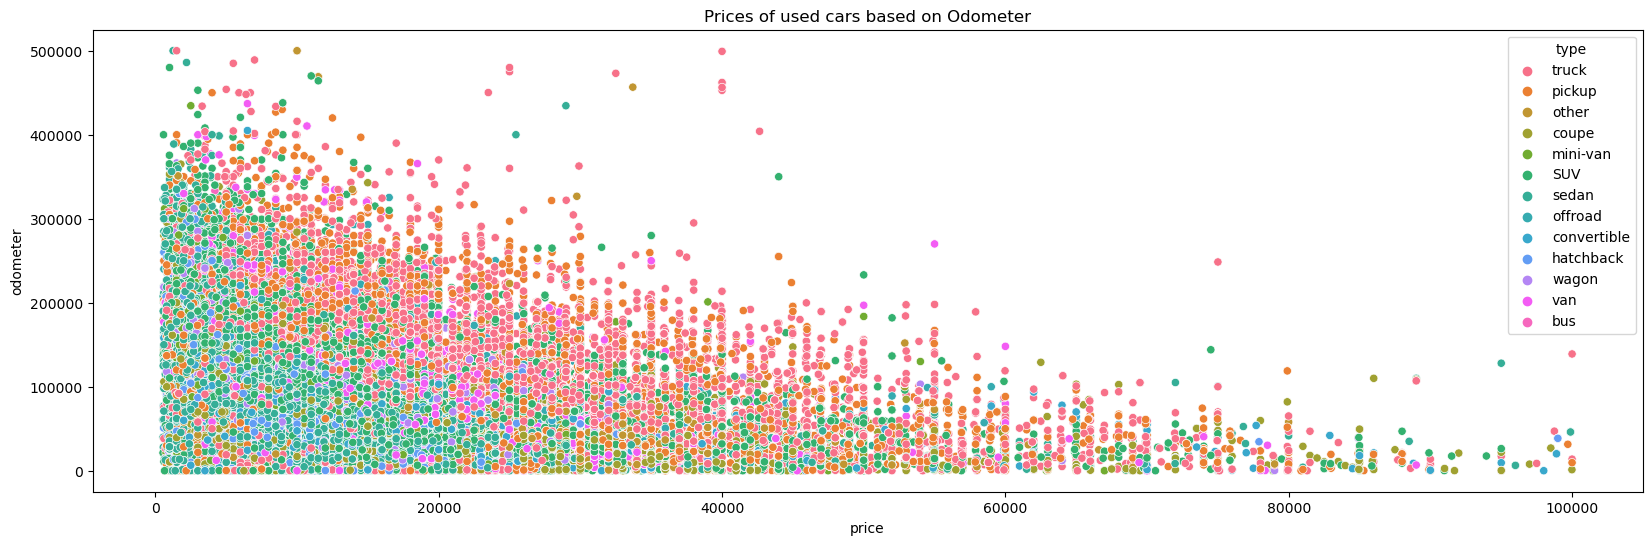

In [351]:
# Look at Type/odometer
plt.figure(figsize=(20, 6))
scatter = sns.scatterplot(data=df_cleaned, x="price", y="odometer", hue='type', sizes=(20, 200))

# Add title
plt.title('Prices of used cars based on Odometer')

# Show plot
plt.show()

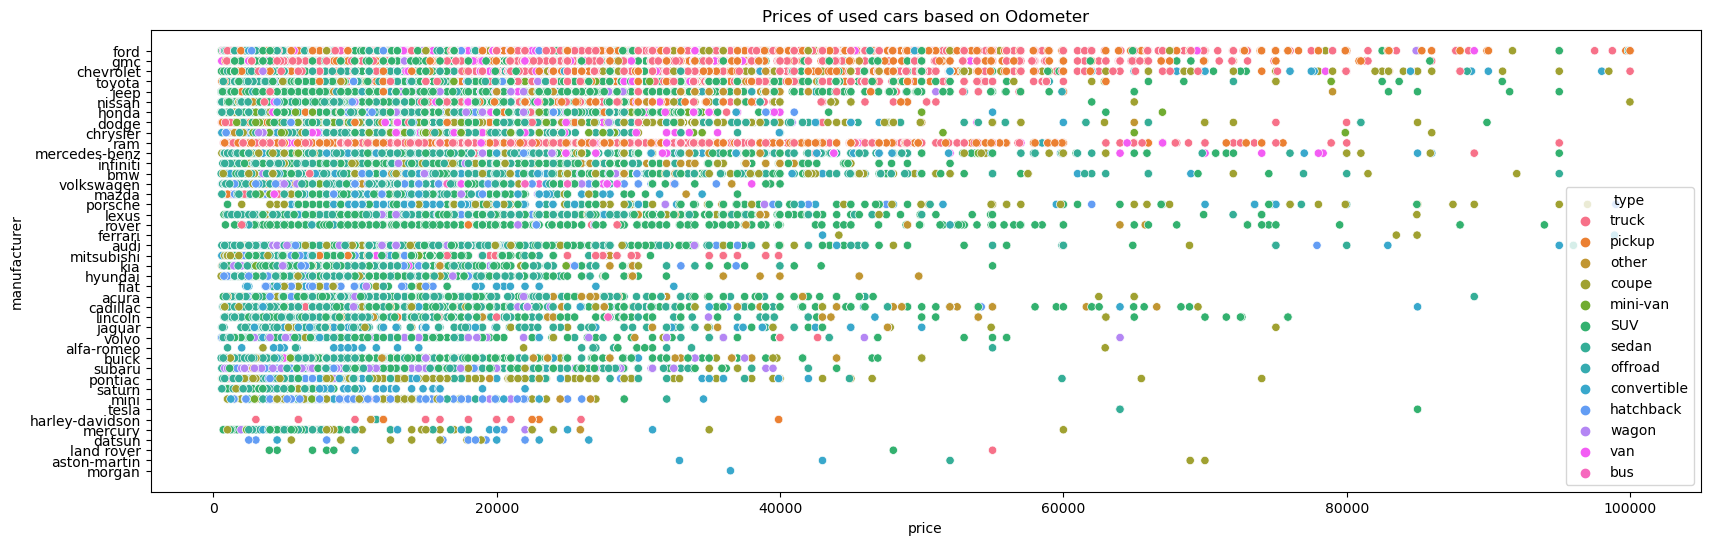

In [352]:
# Look at Manufacturer
plt.figure(figsize=(20, 6))
scatter = sns.scatterplot(data=df_cleaned, x="price", y="manufacturer", hue='type', sizes=(20, 200))

# Add title
plt.title('Prices of used cars based on Manufacturer')

# Show plot
plt.show()

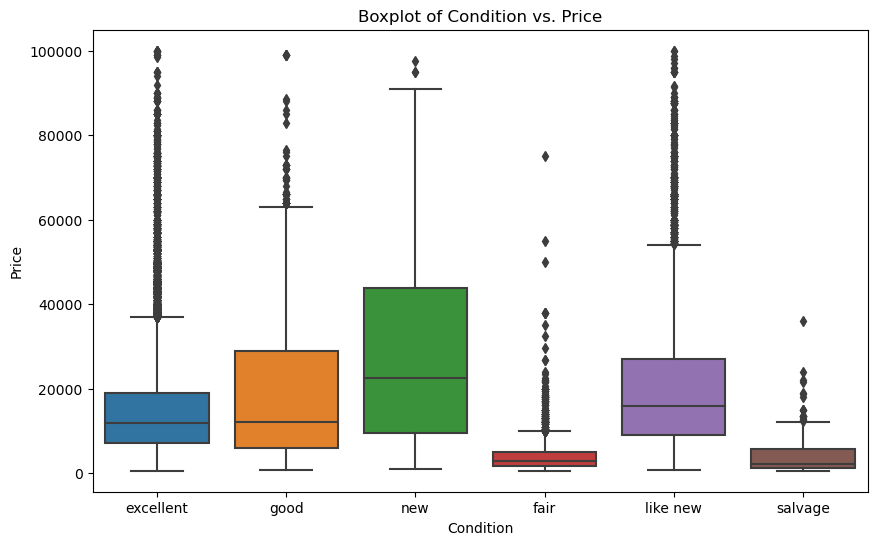

In [361]:
# Create the boxplot of condition
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='price', data=df_cleaned)
plt.title('Boxplot of Condition vs. Price')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.show()

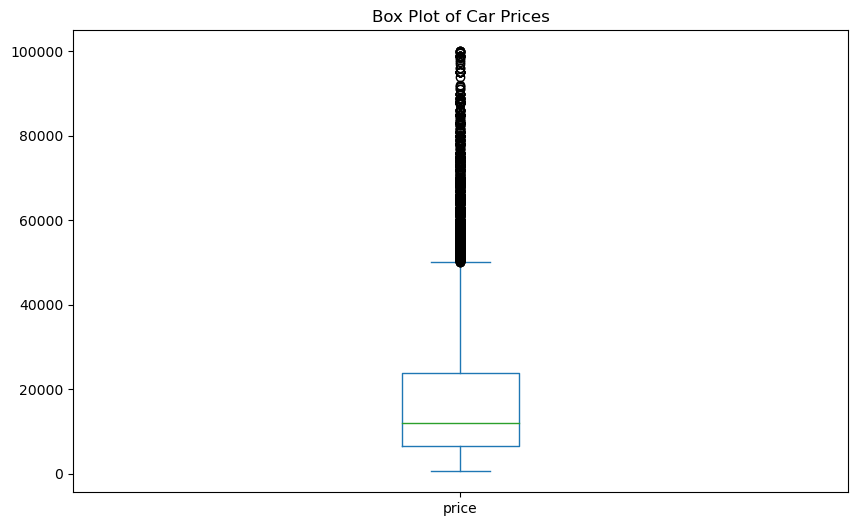

In [368]:
#Price Distribution
# Box Plot
plt.figure(figsize=(10, 6))
df_cleaned['price'].plot.box()
plt.title('Box Plot of Car Prices')
plt.show()

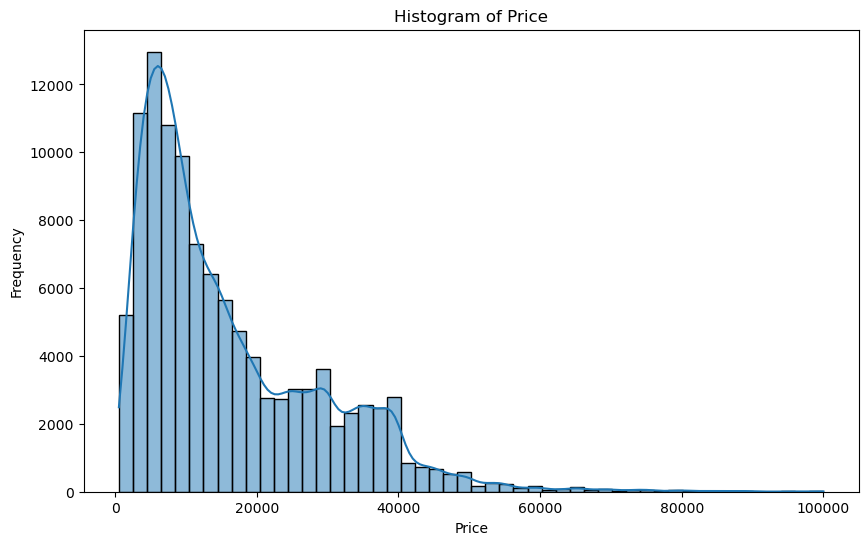

In [318]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['price'], bins=50, kde=True)
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [319]:
#Price is too skewed and needs to be normalized
df_cleaned['log_price'] = np.log(df_cleaned['price'])


In [320]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 110332 entries, 31 to 426878
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   price          110332 non-null  int64  
 1   year           110332 non-null  float64
 2   manufacturer   110332 non-null  object 
 3   condition      110332 non-null  object 
 4   fuel           110332 non-null  object 
 5   odometer       110332 non-null  float64
 6   drive          110332 non-null  object 
 7   type           110332 non-null  object 
 8   paint_color    110332 non-null  object 
 9   cylinders_num  110332 non-null  int64  
 10  log_price      110332 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 10.1+ MB


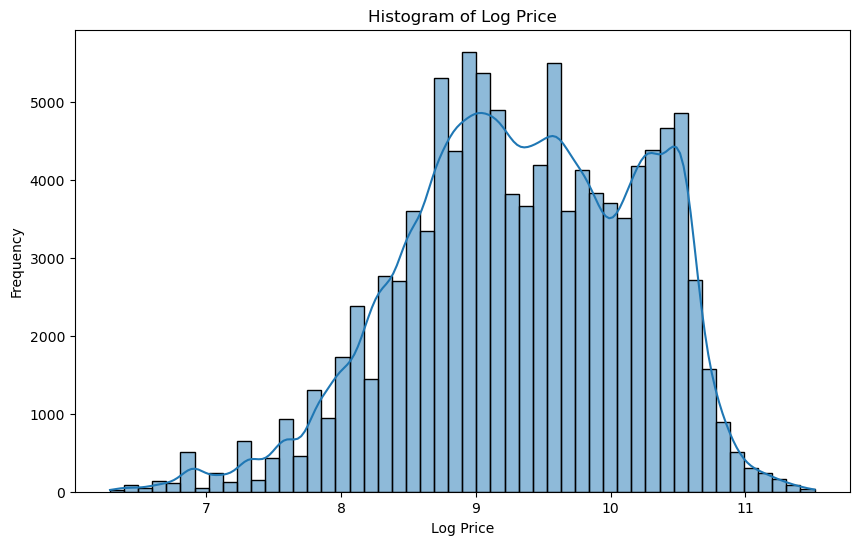

In [321]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['log_price'], bins=50, kde=True)
plt.title('Histogram of Log Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [339]:
# Define catagorical an numeric columns for feature engineering
categorical_cols = ['condition', 'fuel', 'manufacturer', 'drive', 'type', 'paint_color']
numerical_cols = ['year', 'odometer', 'cylinders_num']

In [332]:
# Pipeline for numerical features
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()) 
])

In [333]:
# Pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [340]:
# Combine numerical and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ])

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [ ]:
# Define the target variable
y = df_cleaned['log_price']

# Define the features
X = df_cleaned.drop(columns=['price', 'log_price'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Linear Regression Model

In [341]:
# Create a full pipeline with preprocessing for simple linear regression model
linear_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [378]:
#Fit the model
linear_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer',
                                                   'cylinders_num']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['condition', 'fuel',
                                                   'manufacturer', 'drive',
                                                   'type', 'paint_color'])])),
                ('regressor', LinearRegression())])

In [380]:
#Run Prediction against the model:
y_pred_linear = linear_model_pipeline.predict(X_test)

#Get MSE 
mse = mean_squared_error(y_test, y_pred_ridge)
print(f"Test set MSE: {mse}")

Test set MSE: 0.23631725170913645


In [379]:
#Perform 5 Fold Cross Validation against linear model
cv_scores = cross_val_score(linear_model_pipeline, X, y, cv=5, scoring=mse_scorer)

# Calculate the mean of the cross-validation scores
linear_model_mean_cv_score = np.mean(cv_scores)

print(f"5-Fold Cross-Validation MSE Scores: {cv_scores}")
print(f"Mean Cross-Validation MSE: {linear_model_mean_cv_score}")

5-Fold Cross-Validation MSE Scores: [0.25699234 0.22548534 0.22835869 0.2540184  0.22897998]
Mean Cross-Validation MSE: 0.23876695124968536


### Polynomial Features + Linear Regression Model

In [381]:
# Polynomial Regression Pipeline
polynomial_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

In [391]:
#Define Parameters for GridSearch
param_grid = {
    'poly__degree': [1, 2, 3]  # degrees to try
}

In [393]:
# Define the scoring metric (mean squared error)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=True)

#Create Grid=Search
grid_search = GridSearchCV(polynomial_model_pipeline, param_grid, cv=3, scoring=mse_scorer)

In [411]:
# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'poly__degree': 3}
Best cross-validation score:  0.24494523276580002


### Ridge Regression Model

In [395]:
# Ridge Regression Pipeline
ridge_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])


In [408]:
#Define Parameters for GridSearch
param_grid_alpha = {
    'regressor__alpha':  10**np.linspace(-5,4,10)  # Alphas to try
}

In [409]:
#Create Grid=Search
grid_search_ridge = GridSearchCV(ridge_model_pipeline, param_grid_alpha, cv=5, scoring='neg_mean_squared_error')

In [410]:
# Fit GridSearchCV
grid_search_ridge.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", grid_search_ridge.best_params_)
print("Best cross-validation score: ", -grid_search_ridge.best_score_)

Best parameters found:  {'regressor__alpha': 1e-05}
Best cross-validation score:  0.2373519034653891


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

From the modeling results, both the Simple Linear Regression and Ridge Regression models performed similarly well. The Ridge Regression model with a very small alpha value slightly outperformed the Simple Linear Regression model, achieving a Mean Squared Error (MSE) of 0.237 compared to 0.238 for the Simple Linear Regression. However, given the minimal difference in MSE and the extremely small alpha value, the tradeoff between using Ridge Regression and Simple Linear Regression is negligible.

Considering this, we can proceed with the Simple Linear Regression model for its simplicity and ease of interpretation. We will extract the coefficients from the linear regression model to present the outcomes to the customer, providing clear insights into the impact of each feature on the car price.

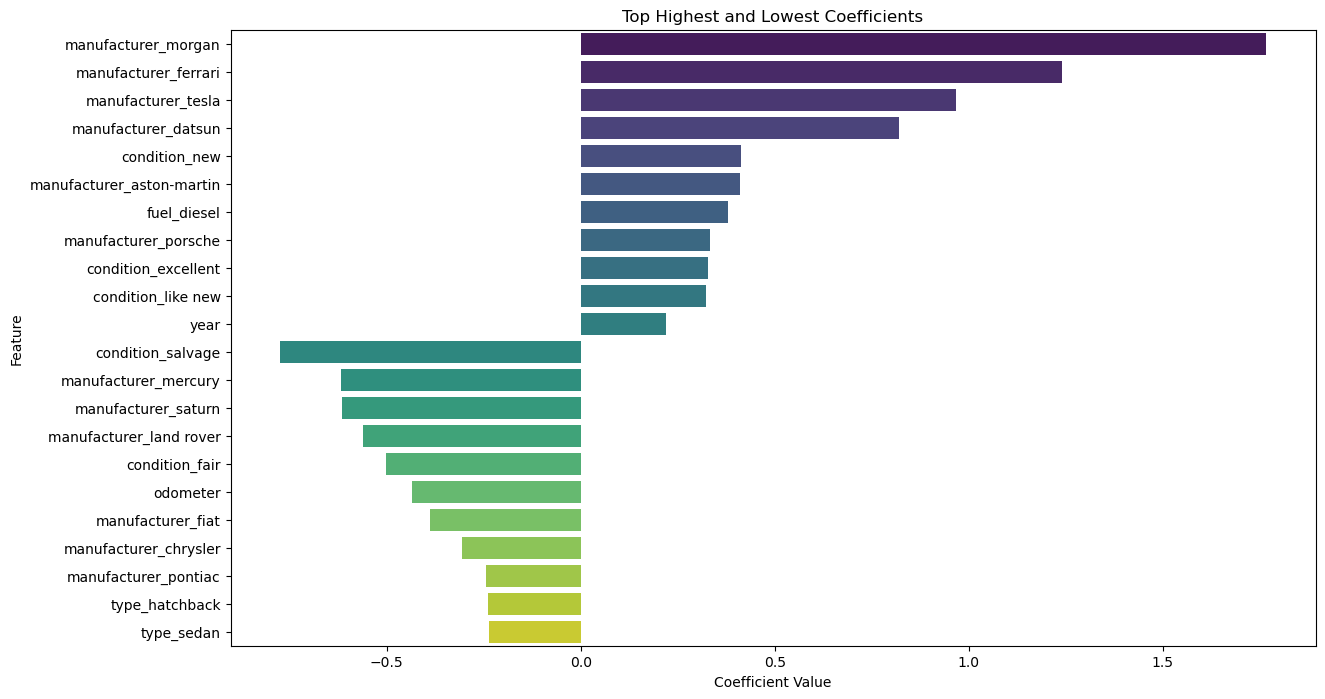

In [415]:
# Get the feature names after one-hot encoding
feature_names = numerical_cols + list(linear_model_pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols))

# Get the coefficients from the model
coefficients = linear_model_pipeline.named_steps['regressor'].coef_

# Create a DataFrame to display feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

#Selet Highest and lowest coefficients for the chart
top_11_highest = coef_df.nlargest(11, 'Coefficient')
top_11_lowest = coef_df.nsmallest(11, 'Coefficient')
top_11_combined = pd.concat([top_11_highest, top_11_lowest])


# Set the plot size
plt.figure(figsize=(14, 8))

# Create a bar plot
sns.barplot(x='Coefficient', y='Feature', data=top_11_combined, palette='viridis')

# Add titles and labels
plt.title('Top Highest and Lowest Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

# Display the plot
plt.show()

In [416]:
top_11_combined

,Feature,Coefficient
44,manufacturer_morgan,1.766658
25,manufacturer_ferrari,1.240470
52,manufacturer_tesla,0.968397
23,manufacturer_datsun,0.821338
7,condition_new,0.413365
16,manufacturer_aston-martin,0.409981
9,fuel_diesel,0.379590
47,manufacturer_porsche,0.333110
3,condition_excellent,0.328815
6,condition_like new,0.321811


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### Car Price Prediction Model Findings

#### Introduction
We have developed a car price prediction model using linear regression, which helps to understand how various features influence the price of a car. Below are the key findings.

#### Key Insights

1. **Impact of Car Manufacturers**:
    - **Morgan (+1.77)** and **Ferrari (+1.24)** have the highest positive impact on car prices. Cars from these manufacturers are valued significantly higher compared to other brands.
    - **Tesla (+0.97)** and **Datsun (+0.82)** also positively influence car prices, indicating a premium value associated with these brands.
    - Conversely, cars from manufacturers like **Mercury (-0.62)**, and **Saturn (-0.62)** tend to be valued lower.

2. **Condition of the Car**:
    - **New cars (+0.41)** and those in **excellent condition (+0.33)** significantly increase the price.
    - **Like new (+0.32)** and **good condition (+0.33)** also positively impact the price, but to a slightly lesser extent.
    - **Salvage (-0.78)** and **fair condition (-0.50)** negatively impact the price, indicating a substantial decrease in value.

3. **Year and Odometer**:
    - **Year (+0.22)**: Newer cars tend to be priced higher.
    - **Odometer (-0.44)**: Higher mileage reduces the car’s value, which is expected as wear and tear increase with usage.

4. **Fuel Type**:
    - **Diesel (+0.38)** cars have a higher valuation compared to other fuel types, likely due to their efficiency and longevity.

5. **Car Type**:
    - **Hatchback (-0.24)** and **Sedan (-0.24)** types slightly reduce the car price compared to other car types.

#### Additional Considerations

- **Data Representation**: The high coefficients for rare manufacturers (e.g., Morgan, Ferrari) might be influenced by a smaller number of observations. We ensure these insights are robust by validating them with cross-validation techniques.
- **Regularization**: We found that minimal regularization was needed, suggesting that the model is very close to a simple linear regression. This means the coefficients are reliable, but it is worth keeping an eye on the potential for overfitting with very specific categories.

#### Conclusion

The model provides a detailed understanding of how various factors impact car prices. The most influential factors include the car manufacturer, condition, year, and odometer. These insights can help in making informed decisions regarding car valuations and pricing strategies.

### Recommendations

1. **Focus on Premium Brands**: Emphasize marketing and sales strategies for high-value brands like Morgan, Ferrari, and Tesla.
2. **Condition Management**: Implement programs to maintain and improve the condition of cars, as this significantly impacts their resale value.
3. **Monitor Mileage**: Highlight the importance of lower mileage in pricing strategies and customer communications.
4. **Fuel Efficiency**: Promote diesel cars where applicable due to their higher perceived value.